In [1]:
!curl -L bit.ly/rdkit-colab | tar xz -C /

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   163  100   163    0     0    652      0 --:--:-- --:--:-- --:--:--   654
100   133  100   133    0     0    241      0 --:--:-- --:--:-- --:--:--   517
100   651  100   651    0     0    826      0 --:--:-- --:--:-- --:--:--   826
100 29.6M  100 29.6M    0     0  9276k      0  0:00:03  0:00:03 --:--:-- 16.2M


In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
  from rdkit import Chem
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.')
  exit()

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import DataStructs
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  



In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/smiles')

In [5]:
!git clone https://github.com/stat-eklee/smiles_data.git

Cloning into 'smiles_data'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [6]:
!unzip -qq "/content/drive/My Drive/Colab Notebooks/smiles/smiles_data/train_re.zip" -d 'train'
!unzip -qq "/content/drive/My Drive/Colab Notebooks/smiles/smiles_data/train_re (2).zip" -d 'train'
!unzip -qq "/content/drive/My Drive/Colab Notebooks/smiles/smiles_data/train_re (3).zip" -d 'train'
!unzip -qq "/content/drive/My Drive/Colab Notebooks/smiles/smiles_data/train_re (4).zip" -d 'train'
!unzip -qq "/content/drive/My Drive/Colab Notebooks/smiles/smiles_data/test.zip" -d 'test'


In [7]:
# training file 불러오기 
with open('./smiles_data/train.csv', 'r') as csv_file:
    data = csv_file.read()
data

'file_name,SMILES\ntrain_0.png,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C\ntrain_1.png,CC(=O)OC(CC(=O)O)C[N+](C)(C)C\ntrain_2.png,C1=CC(C(C(=C1)C(=O)O)O)O\ntrain_3.png,CC(CN)O\ntrain_4.png,C(C(=O)COP(=O)(O)O)N\ntrain_5.png,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl\ntrain_6.png,CCN1C=NC2=C(N=CN=C21)N\ntrain_7.png,CCC(C)(C(C(=O)O)O)O\ntrain_8.png,C1(C(C(C(C(C1O)O)OP(=O)(O)O)O)O)O\ntrain_9.png,C(CCl)Cl\ntrain_10.png,C1=C(C=C(C(=C1O)O)O)O\ntrain_11.png,C1=CC(=C(C=C1Cl)Cl)Cl\ntrain_12.png,CCCCCC(=O)C=CC1C(CC(=O)C1CCCCCCC(=O)O)O\ntrain_13.png,CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C\ntrain_14.png,C1CCC(=O)NCCCCCC(=O)NCC1\ntrain_15.png,C1C=CC(=NC1C(=O)O)C(=O)O\ntrain_16.png,C(C(C(C(=O)C(=O)C(=O)O)O)O)O\ntrain_17.png,C1=CC(=C(C(=C1)O)O)C(=O)O\ntrain_18.png,C1=CC(=C(C(=C1)O)O)CCC(=O)O\ntrain_19.png,CCC(C(=O)C)(C(=O)O)O\ntrain_20.png,CC(=O)C(C)(C(=O)O)O\ntrain_21.png,C(=CC(=C(C(=O)O)N)C(=O)O)C=O\ntrain_22.png,C(C(C(C1(C(N(C2C(N1O)C(=O)NC(=N2)N)O)O)O)O)O)O\ntrain_23.png,CC(=O)C(=O)C1=NC2C(N=C(NC2=O)N)N(C1O)O\ntr

In [8]:
all_captions = []
all_img_name_vector = []
PATH = './train/'

for line in data.split('\n')[1:-1]:
    image_id, smiles = line.split(',')
    caption = '<' + smiles + '>'
    full_image_path = PATH + image_id

    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)


In [9]:
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=42)
len(img_name_vector)

8910

In [10]:
num_examples = int(len(img_name_vector) * 0.7) # 학습에 사용할 데이터 수 > 전체의 70% 만 사용
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.nasnet.preprocess_input(img) # nasnet backbone 사용
    return img, image_path

image_model = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

20004864/19993432 [==============================] - 0s 0us/step


In [12]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

encode_train = sorted(set(img_name_vector))

In [13]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)


In [14]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img) #배치별 feature 추출 저장 
    #print(batch_features.shape) # (16, 7, 7, 1056) 
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) # reshape 
    #print(batch_features.shape) #(16, 49, 1056)
    #break
    for bf, p in zip(batch_features, path): # numpy로 저장 
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


100%|██████████| 390/390 [03:35<00:00,  1.81it/s]


In [15]:
## 최대길이 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_captions)
#print(train_captions)
max_length #72 

72

In [16]:
## SMILES 토큰화
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(train_captions) #fit_on_texts : 문자 데이터 입력 > 리스트 형태로 변환 

top_k = len(tokenizer.word_index) # word_index : 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리 반환
top_k 

49

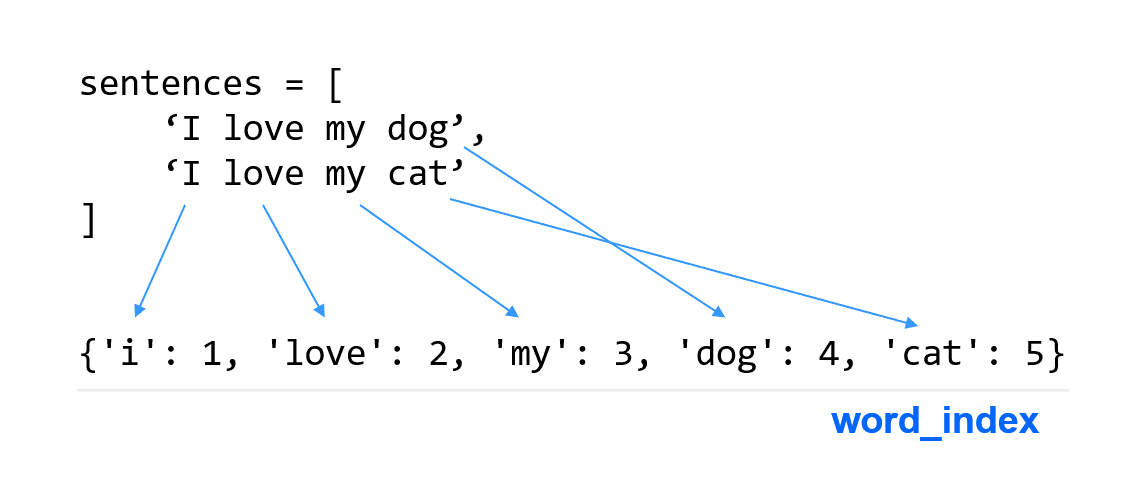

출처 : https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html

In [17]:
train_seqs = tokenizer.texts_to_sequences(train_captions) # texts_to_sequences : 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환 
print("sequence: ", train_seqs[0])
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') # pad_sequences : 서로 다른 개수의 단어로 이루어진 문장을 같은 길이로 만들어주기 위해 패딩 사용 
print("padding: ", cap_vector[0])

img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.02, random_state=42) # train / test set 으로 분할

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

sequence:  [8, 1, 2, 1, 1, 3, 1, 1, 1, 3, 2, 5, 4, 5, 4, 7, 9]
padding:  [8 1 2 1 1 3 1 1 1 3 2 5 4 5 4 7 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(6112, 6112, 125, 125)

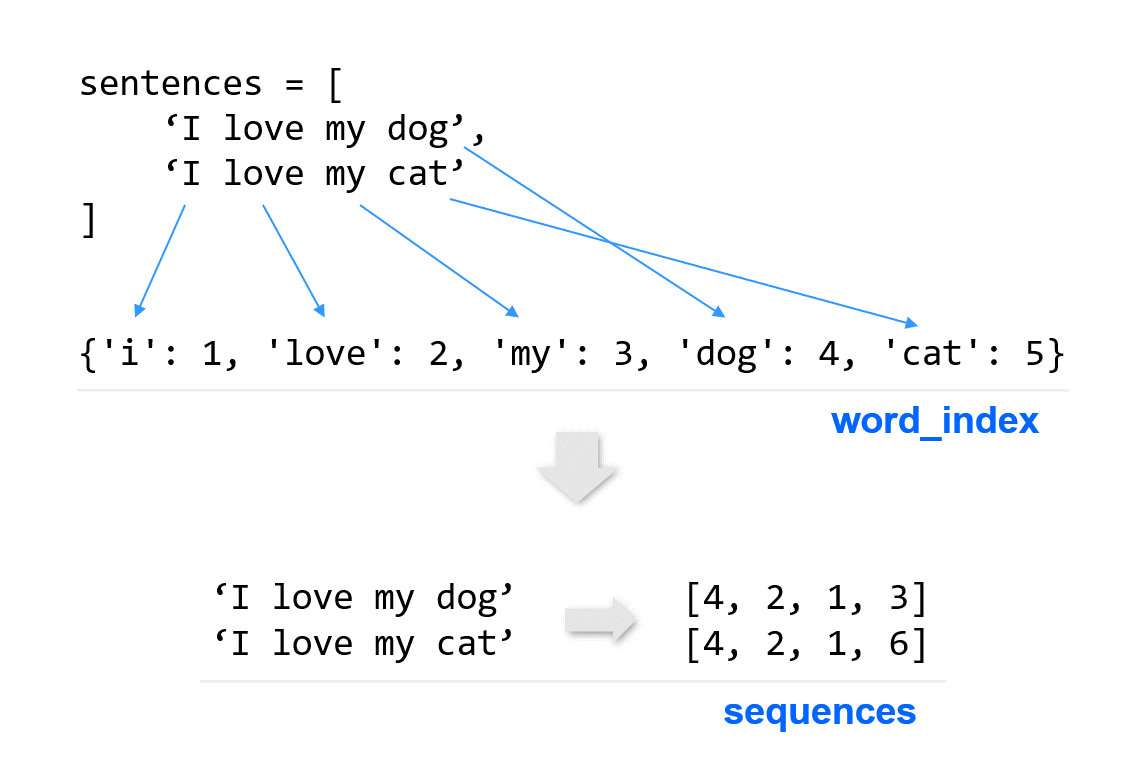


In [18]:
#하이퍼 파라미터 및 학습에 필요한 변수 지정

BATCH_SIZE = 512
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64
#데이터셋 정의 함수
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [20]:
#검증 데이터셋 준비
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
# Attention Layer 정의
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [22]:
# CNN_Encoder 정의
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x) # fully connected 
        x = tf.nn.relu(x) # relu
        return x

In [23]:
# RNN_Decoder 정의
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.fc2(x)

        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [24]:
# 모델 생성
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [25]:
## 학습 Optimizer & Loss Function 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # Sparse Categorical Crossentropy

In [26]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [27]:
#CheckPoint 지정
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=25)

In [28]:
# 복원
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)


In [29]:
#Loss 기록용 List
loss_plot = []

In [30]:
#학습 정의
@tf.function
def train_step(img_tensor, target, validation=False):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    total_loss = (loss / int(target.shape[1]))
    
    return loss, total_loss


In [31]:
# 학습
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    loss_plot.append(total_loss / (batch+1))
    
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/(batch+1)))
    
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8382
Epoch 1 Loss 1.239173
Time taken for 1 epoch 210.51795864105225 sec

Epoch 2 Batch 0 Loss 0.9419
Epoch 2 Loss 0.879515
Time taken for 1 epoch 25.654261827468872 sec

Epoch 3 Batch 0 Loss 0.8058
Epoch 3 Loss 0.811045
Time taken for 1 epoch 25.560208320617676 sec

Epoch 4 Batch 0 Loss 0.7465
Epoch 4 Loss 0.779041
Time taken for 1 epoch 25.628376245498657 sec

Epoch 5 Batch 0 Loss 0.7665
Epoch 5 Loss 0.763080
Time taken for 1 epoch 25.553749322891235 sec

Epoch 6 Batch 0 Loss 0.7545
Epoch 6 Loss 0.753809
Time taken for 1 epoch 25.629822254180908 sec

Epoch 7 Batch 0 Loss 0.7452
Epoch 7 Loss 0.747075
Time taken for 1 epoch 25.594478368759155 sec

Epoch 8 Batch 0 Loss 0.7369
Epoch 8 Loss 0.740897
Time taken for 1 epoch 25.603271484375 sec

Epoch 9 Batch 0 Loss 0.7463
Epoch 9 Loss 0.735508
Time taken for 1 epoch 25.559943437576294 sec

Epoch 10 Batch 0 Loss 0.7264
Epoch 10 Loss 0.729475
Time taken for 1 epoch 25.60421323776245 sec



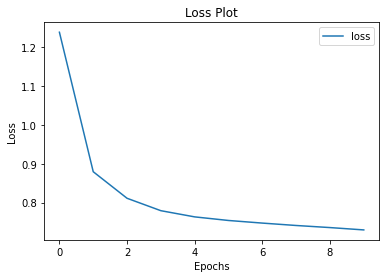

In [32]:
# 시각화
plt.plot(loss_plot, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
## 검증
# Predict 함수 정의
# 가장 높은 확률로 예측
def predict(img_tensor):
    hidden = decoder.reset_state(batch_size=img_tensor.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<']] * img_tensor.shape[0], 1)
    features = encoder(img_tensor)
    
    result = []
    
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predictions = np.argmax(predictions, axis=1)
        result.append(predictions)
        dec_input = tf.expand_dims(predictions, 1)
    
    return np.array(result)

In [ ]:
# 비교적 높은 확률들로 예측
def predict_(img_tensor):
    hidden = decoder.reset_state(batch_size=img_tensor.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<']] * img_tensor.shape[0], 1)
    features = encoder(img_tensor)
    
    result = []
    
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predictions = tf.random.categorical(predictions, 1)[:, 0].numpy()
        result.append(predictions)
        dec_input = tf.expand_dims(predictions, 1)
    
    return np.array(result)

def map_func_pred(img_name):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor

In [ ]:
# 가장 높은 확률로 검증셋을 예측
val_result = []
for batch in tqdm(dataset_val):
    val_result.extend(predict(batch[0]).T)
val_result = np.array(val_result)
val_result

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 3, 2, ..., 1, 3, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
# 예측 결과 SMILES로 변환
preds = []
for rid in range(cap_val.shape[0]):
    pred = ''.join([tokenizer.index_word[i] for i in val_result[rid]])
    pred = pred.split('>')[0]
    preds.append(pred)
preds

In [ ]:
#예측 결과가 SMILES 규칙에 맞는지 검사
error_idx = []
for i, pred in enumerate(preds):
    m = Chem.MolFromSmiles(pred) 
    if m == None:
        error_idx.append(i)
error_idx = np.array(error_idx)
error_idx_ = error_idx.copy()
error_idx_

array([  2,   5,   7,  45,  51,  73,  83,  92, 100, 110, 113])

In [ ]:
#대부분의 결과가 SMILES 규칙에 맞게 예측할 때까지 반복
drop_error = []
from IPython.display import clear_output
while True:
    error_idx_dict = {}
    for i, e in enumerate(error_idx_):
        error_idx_dict[i] = e
    print(error_idx_)
    img_name_val_, cap_val_ = np.array(img_name_val)[error_idx_], np.array(cap_val)[error_idx_]
    dataset_val_ = tf.data.Dataset.from_tensor_slices((img_name_val_, cap_val_))
    dataset_val_ = dataset_val_.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_val_ = dataset_val_.batch(BATCH_SIZE)
    dataset_val_ = dataset_val_.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    val_result_ = []
    for batch in dataset_val_:
        val_result_.extend(predict_(batch[0]).T)
    val_result_ = np.array(val_result_)

    preds_ = []
    for rid in range(val_result_.shape[0]):
        pred = ''.join([tokenizer.index_word[i] for i in val_result_[rid] if i not in [0]])
        pred = pred.split('>')[0]
        preds_.append(pred)
    
    for i, pred in enumerate(preds_):
        m = Chem.MolFromSmiles(pred)
        if m != None:
            preds[error_idx_dict[i]] = pred
            drop_idx = np.where(error_idx==error_idx_dict[i])[0]
            drop_error.append(drop_idx[0])
    error_idx_ = np.delete(error_idx, drop_error)
    clear_output(wait=True)
    print(len(list(drop_error)), '/', error_idx.shape[0])
    
    if error_idx.shape[0]-len(list(drop_error)) < 10 :
        break

2 / 11


In [ ]:
#검증 데이터셋 Accuracy
    
count = 0
answer = []
for rid, pred in enumerate(preds):
    true = ''.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])[1:-1]
    answer.append(true)
    if true == pred:
        count+=1
print('val_accuracy : ', count/cap_val.shape[0])
#검증 데이터셋 Tanimoto Similarity
score = []
for i, pred in enumerate(preds):
    m1 = Chem.MolFromSmiles(answer[i])
    m2 = Chem.MolFromSmiles(pred)
    
    if m2 != None:
        fp1 = Chem.RDKFingerprint(m1)
        fp2 = Chem.RDKFingerprint(m2)

        similarity = DataStructs.FingerprintSimilarity(fp1,fp2)
    else:
        similarity = 0
    score.append(similarity)
    
print('val_similarity :', np.mean(score))

val_accuracy :  0.0
val_similarity : 0.03700808542006388


In [ ]:
## TestSet 예측
TEST_PATH = './test/'

with open('./smiles_data/test.csv', 'r') as csv_file:
    data = csv_file.read()
    
test_img_path = []

for line in data.split('\n')[1:-1]:
    image_id, _ = line.split(',')
    full_image_path = TEST_PATH + image_id

    test_img_path.append(full_image_path)

In [ ]:
#빠른 학습을 위해 NASNetMobile에서 추출된 feature를 로컬디스크에 저장
encode_train = sorted(set(test_img_path))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        

100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


In [ ]:
#배치사이즈로 데이터셋 준비
dataset_test = tf.data.Dataset.from_tensor_slices((test_img_path))
dataset_test = dataset_test.map(lambda item1: tf.numpy_function(map_func_pred, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# 결과 예측
test_result = []
for batch in tqdm(dataset_test):
    test_result.extend(predict(batch[0]).T)
test_result = np.array(test_result)


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [ ]:
#SMILES로 변환
preds = []
for rid in range(len(test_img_path)):
    pred = ''.join([tokenizer.index_word[i] for i in test_result[rid]])
    pred = pred.split('>')[0]
    preds.append(pred)




In [ ]:
## 검증 데이터셋과 마찬가지로 SMILES 규칙을 만족하지 않은 결과 재예측
error_idx = []
for i, pred in enumerate(preds):
    m = Chem.MolFromSmiles(pred)
    if m == None:
        error_idx.append(i)
error_idx = np.array(error_idx)
error_idx_ = error_idx.copy()



In [ ]:
drop_error = []
while True:
    error_idx_dict = {}
    for i, e in enumerate(error_idx_):
        error_idx_dict[i] = e
    print(error_idx_)
    img_name_test_ = np.array(test_img_path)[error_idx_]
    dataset_test_ = tf.data.Dataset.from_tensor_slices((img_name_test_))
    dataset_test_ = dataset_test_.map(lambda item1: tf.numpy_function(map_func_pred, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_test_ = dataset_test_.batch(BATCH_SIZE)
    dataset_test_ = dataset_test_.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    test_result_ = []
    for batch in dataset_test_:
        test_result_.extend(predict_(batch[0]).T)
    test_result_ = np.array(test_result_)

    preds_ = []
    for rid in range(test_result_.shape[0]):
        pred = ''.join([tokenizer.index_word[i] for i in test_result_[rid] if i not in [0]])
        pred = pred.split('>')[0]
        preds_.append(pred)
    
    for i, pred in enumerate(preds_):
        m = Chem.MolFromSmiles(pred)
        if m != None:
            preds[error_idx_dict[i]] = pred
            drop_idx = np.where(error_idx==error_idx_dict[i])[0]
            drop_error.append(drop_idx[0])
    error_idx_ = np.delete(error_idx, drop_error)
    clear_output(wait=True)
    print(len(list(drop_error)), '/', error_idx.shape[0])
    
    if error_idx.shape[0]-len(list(drop_error)) < 10 :
        break

4 / 12


In [ ]:
res = pd.read_csv('./smiles_data/test.csv')
res['SMILES'] = np.array(preds)
res

,file_name,SMILES
0,pap_1_01.JPG,CC
1,pap_1_02.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,pap_1_03.JPG,Cl
3,pap_1_04.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
4,pap_1_05.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
...,...,...
107,pap_5_26.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
108,pap_5_27.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
109,pap_5_28.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
110,pap_5_29.JPG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
